In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from copy import deepcopy
from IPython.display import clear_output

**1. K-means with sklearn**

Firstly, we generate some fake data with sklearn make_blobs() function, and make a plot of the blobs:

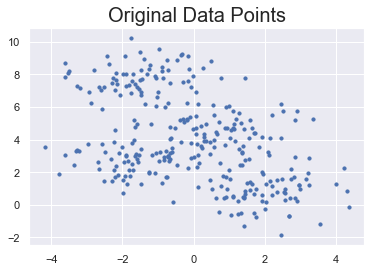

[[ 0.02458305  2.96215652]
 [-1.52392631  7.12573205]
 [ 1.27450825  5.63017322]
 [-0.86552334  7.80121774]
 [ 0.74874067  2.55579434]]


In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=1, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=10);
plt.title('Original Data Points', fontsize=20)
plt.show()

# print out the first 5 rows of our X
print (X[:5,:])

From the above plot we can see there might be four groups of points. But how can we actually tell whether a point belongs to which cluster? The answer is <b>K-means</b>! Implementing k-means from scratch is a little bit tricky here but don't worry, sklearn already provided a solution for us! 

To perform k-means, first we would like to import the Kmeans class from sklearn and initialize a Kmeans instance:

In [3]:
from sklearn.cluster import KMeans
num_clusters = 4
indices = np.random.randint(len(X), size=(num_clusters))
centers = X[indices,:] 
km = KMeans(n_clusters=num_clusters, max_iter=5,init=centers, n_init=1)

Now we make a plot to have a look at the initial centers (They are random but there are smarter initialization strategies!):

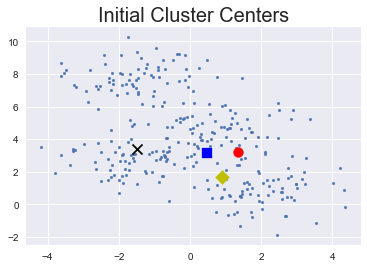

In [4]:
markers = ['o','x','s','D']
colors = ['r','black','b','y']
plt.scatter(X[:, 0], X[:, 1], s=7)
for ind in range(len(markers)):
    plt.scatter(centers[ind, 0], centers[ind, 1], c=colors[ind], s=100, marker=markers[ind])
plt.title('Initial Cluster Centers', fontsize=20)
plt.show()

#### What does the parameters mean?

| Parameters | Description |
| --- |:---:|
| `n_clusters` | **Number of clusters** |
| `max_iter` | **Maximum iterations.** |
| `init` | **Initialization method of centroids, either random, kmeans++ or an array** |
| |

#### What can you do with a KMeans Object?

| Object Method | Description |
| --- |:---:|
| `km.fit()` | **Compute k-means clustering..** |
| `km.predict()` | **Predict the closest cluster each sample in X belongs to.** |
| `km.labels_` | **Labels of each point** |
| `km.cluster_centers_`  |	**Coordinates of cluster centers..** |

To perform k-means clustering algorithm on our data, we simply do:

In [5]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True,
    init=array([[ 1.3527 ,  3.20439],
       [-1.47741,  3.41172],
       [ 0.46546,  3.12316],
       [ 0.89909,  1.67886]]),
    max_iter=5, n_clusters=4, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Cheers! We have finished the most of our algorithm. To find out which cluster does a point belongs to, we use the <b>predict</b> function. This gives us a list of labels indicating the cluster of data points:

In [6]:
predicted_clusters = km.predict(X)
print (predicted_clusters)

[2 1 0 1 0 3 2 0 1 1 2 1 0 1 3 0 0 3 2 2 3 3 0 2 2 2 3 0 2 0 1 1 0 1 1 1 1
 1 2 3 0 2 1 0 2 2 1 2 1 3 2 3 1 3 0 2 1 2 1 3 1 0 1 2 2 2 1 3 1 2 0 0 1 2
 2 1 2 0 3 1 3 0 3 3 1 0 3 0 1 1 0 3 1 2 2 0 3 3 1 2 1 3 1 3 0 3 3 0 1 0 2
 2 3 1 3 3 1 3 3 0 0 3 2 3 3 3 3 2 3 2 1 2 2 3 1 2 2 1 2 1 1 2 0 2 0 2 1 2
 1 1 1 0 0 0 3 2 1 2 3 0 1 0 0 3 0 2 3 0 3 0 0 1 3 0 2 1 3 3 0 2 3 0 2 2 0
 0 0 0 3 1 2 2 0 0 2 2 2 0 2 1 0 2 3 2 0 2 2 1 0 1 0 2 0 0 1 2 2 3 3 0 1 3
 3 2 3 2 2 1 1 0 0 1 0 3 2 0 3 2 1 2 3 0 3 1 1 1 1 2 2 0 0 2 3 0 2 2 0 3 3
 1 0 0 2 3 1 2 0 1 0 3 3 2 2 3 3 3 3 0 1 1 3 3 0 3 3 3 1 0 1 0 3 3 1 1 1 3
 3 0 1 2]


Now we make another plot to have a look at the final clusters and centroids:

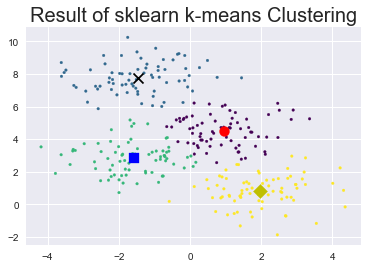

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters, s=7, cmap='viridis')
centers = km.cluster_centers_
for ind in range(len(markers)):
    plt.scatter(centers[ind, 0], centers[ind, 1], c=colors[ind], s=100, marker=markers[ind])
plt.title('Result of sklearn k-means Clustering', fontsize=20)
plt.show()

**2. K-means from scratch!**

Firstly we need a function to calculate the distance between two points. Here we simply use Euclidean distances.

In [8]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

Then we need to define two functions <b>reassign</b> and <b>recompute</b>. They are the most important part of the k-mean algorithm:
1. <b>reassign</b>: After the centroids have been updated, assign each data point to a new cluster (more specifically,  the closest cluster.)
2. <b>recompute</b>: After the data points have been assigned to new clusters, recompute the cluster centroids by taking the mean of all points in each cluster.

In [9]:
def reassign(centers,X, clusters):
    for i in range(len(X)):
        distances = dist(X[i], centers)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    return clusters

def recompute(centers, X, clusters):
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        centers[i] = np.mean(points, axis=0)
    return centers

Then we define the number of clusters and randomly generate the initial centroids. Also, we define two variables to store the previous centroids and the error, which is used to decide when to stop the algorithm

In [10]:
# define the number of clusters
k = 4

# Randomly generate 4 initial clusters
indices = np.random.randint(len(X), size=(k))
centers = X[indices,:] 

# Initializing the clusters
clusters = np.zeros(len(X))

# store the value of the previous centers.
prev_centers = np.zeros(centers.shape)

# set the error in order to control the termination of the algorithm
error = dist(centers, prev_centers, None)
print (error)

12.276893066773866


Here comes the actual excution loop of k-means.

Iteration 0 , Error: 2.715112178105741


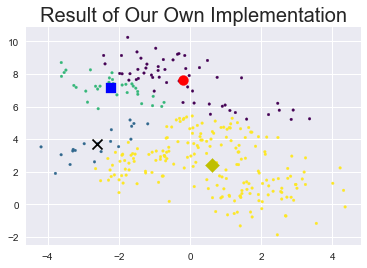

Iteration 1 , Error: 1.2479610107604535


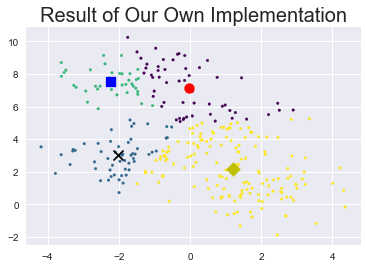

Iteration 2 , Error: 0.8842609650785054


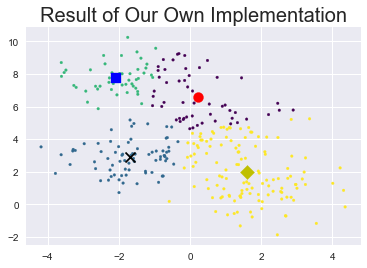

Iteration 3 , Error: 1.0669396909506543


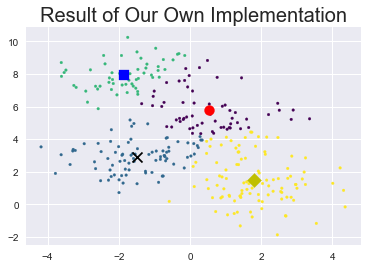

Iteration 4 , Error: 0.8557067417746774


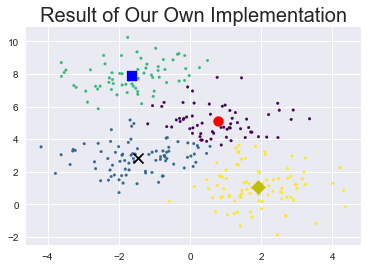

Iteration 5 , Error: 0.4251775662555594


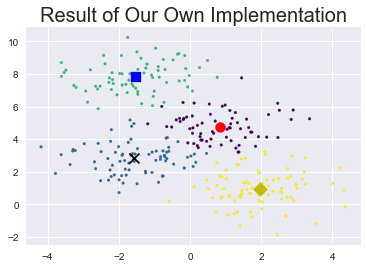

Iteration 6 , Error: 0.169417933131404


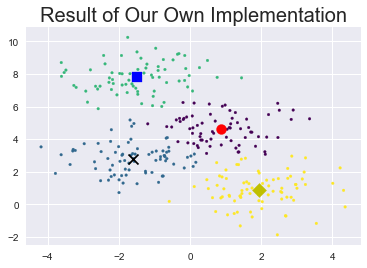

Iteration 7 , Error: 0.10133095146600075


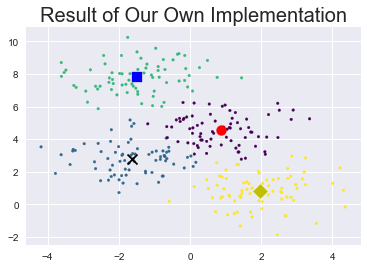

Iteration 8 , Error: 0.06348994173537015


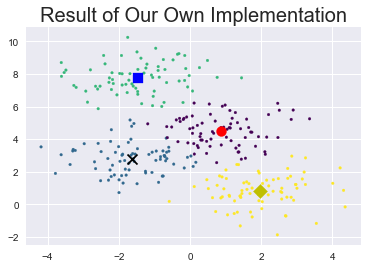

Iteration 9 , Error: 0.0


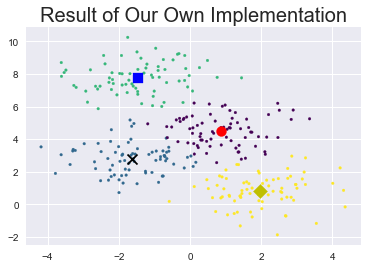

In [11]:
iter = 0
while error != 0:
    # Assign data points to the nearest center.
    clusters = reassign(centers, X, clusters)   
    
    # Store the old center values
    prev_centers = deepcopy(centers)
    
    # Finding the new centers by taking the average value of each cluster
    recompute(centers,X, clusters)
    
    # calculate the move of centroids and determine whether to stop
    error = dist(centers, prev_centers, None)
    print ('Iteration', iter, ', Error:', error)
    
    # visualize the centroids in each iteration:
    plt.scatter(X[:, 0], X[:, 1], c=clusters, s=7, cmap='viridis')
    for ind in range(len(markers)):
        plt.scatter(centers[ind, 0], centers[ind, 1], c=colors[ind], s=100, marker=markers[ind])
    plt.title('Result of Our Own Implementation', fontsize=20)
    plt.show()
#   input()
#   clear_output()
    
    iter +=1

The above code actually does the same thing as sklearn. Now plot the result and have a look of the performance of our own implementation!

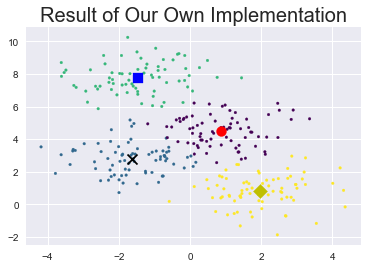

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=7, cmap='viridis')
for ind in range(len(markers)):
    plt.scatter(centers[ind, 0], centers[ind, 1], c=colors[ind], s=100, marker=markers[ind])
plt.title('Result of Our Own Implementation', fontsize=20)
plt.show()